In [1]:
from torchvision import models
import torch.nn as nn
from torchvision.models.feature_extraction import get_graph_node_names
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
from dataset import CustomImageSet
from sklearn.model_selection import train_test_split
from plots import plot_features
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision import transforms

In [2]:
cuda = torch.device("cuda")

In [3]:
resnet50_transforms = transforms.Compose([
    transforms.Resize(232, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop(224),
    transforms.RandomRotation(degrees=30),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.299, 0.244, 0.225])
])

In [4]:
test_path = "C:/Users/voicu/OneDrive/Desktop/licenta/OCT2017/test"

test_dataset = CustomImageSet(test_path, transform=resnet50_transforms)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [5]:
# loading the model
resnet50_features = models.resnet50()
resnet50_features.fc = nn.Linear(resnet50_features.fc.in_features, 4)
resnet50_features.load_state_dict(torch.load("models/resnet50_fine_tuning2.pth"))
resnet50_features.to(cuda)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [6]:
train_nodes, eval_nodes = get_graph_node_names(resnet50_features)

In [7]:
print(train_nodes)

['x', 'conv1', 'bn1', 'relu', 'maxpool', 'layer1.0.conv1', 'layer1.0.bn1', 'layer1.0.relu', 'layer1.0.conv2', 'layer1.0.bn2', 'layer1.0.relu_1', 'layer1.0.conv3', 'layer1.0.bn3', 'layer1.0.downsample.0', 'layer1.0.downsample.1', 'layer1.0.add', 'layer1.0.relu_2', 'layer1.1.conv1', 'layer1.1.bn1', 'layer1.1.relu', 'layer1.1.conv2', 'layer1.1.bn2', 'layer1.1.relu_1', 'layer1.1.conv3', 'layer1.1.bn3', 'layer1.1.add', 'layer1.1.relu_2', 'layer1.2.conv1', 'layer1.2.bn1', 'layer1.2.relu', 'layer1.2.conv2', 'layer1.2.bn2', 'layer1.2.relu_1', 'layer1.2.conv3', 'layer1.2.bn3', 'layer1.2.add', 'layer1.2.relu_2', 'layer2.0.conv1', 'layer2.0.bn1', 'layer2.0.relu', 'layer2.0.conv2', 'layer2.0.bn2', 'layer2.0.relu_1', 'layer2.0.conv3', 'layer2.0.bn3', 'layer2.0.downsample.0', 'layer2.0.downsample.1', 'layer2.0.add', 'layer2.0.relu_2', 'layer2.1.conv1', 'layer2.1.bn1', 'layer2.1.relu', 'layer2.1.conv2', 'layer2.1.bn2', 'layer2.1.relu_1', 'layer2.1.conv3', 'layer2.1.bn3', 'layer2.1.add', 'layer2.1.rel

In [8]:
embeds = {}
def get_activation(name):
    def hook(model, input, output):
        embeds[name] = output
    return hook

In [9]:
conv_layer = resnet50_features.layer4[2].conv3
hook_conv = conv_layer.register_forward_hook(get_activation('layer4.2.conv3'))

In [10]:
def extract_conv_features(dataloader, model, layer):
    model.eval()
    features = []
    labels_list = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(cuda)
            labels = labels.to(cuda)

            _ = model(images)

            features.append(embeds[layer].cpu().numpy())
            labels_list.append(labels.cpu().numpy())

    features = np.concatenate(features)
    labels = np.concatenate(labels_list)
    return features, labels

In [11]:
conv_features, conv_labels = extract_conv_features(test_dataloader, resnet50_features, 'layer4.2.conv3')
hook_conv.remove()

In [12]:
print(f"Convolutional Features shape: {conv_features.shape}")
print(f"Convolutional Labels shape: {conv_labels.shape}")

Convolutional Features shape: (3400, 2048, 7, 7)
Convolutional Labels shape: (3400,)


In [13]:
# KMeans expects 2D array - samples, features
# flatten features
conv_features = conv_features.reshape(conv_features.shape[0], -1)
print(f"Convolutional Features shape: {conv_features.shape}")

Convolutional Features shape: (3400, 100352)


In [14]:
n_clusters = 4

kmeans_conv4 = KMeans(n_clusters=n_clusters, random_state=42).fit(conv_features)
conv_labels4 = kmeans_conv4.predict(conv_features)
conv_centroids4 = kmeans_conv4.cluster_centers_

In [15]:
def KMeansMetrics(features, labels):
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
    knn = KNeighborsClassifier()
    knn.fit(X_train, y_train)

    y_pred = knn.predict(X_test)
    print(classification_report(y_test, y_pred))

    acc = accuracy_score(y_pred,y_test)
    print(f'Accuracy: {acc}')

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       208
           1       0.97      0.98      0.97       285
           2       1.00      0.79      0.88        14
           3       0.93      0.91      0.92       173

    accuracy                           0.95       680
   macro avg       0.96      0.91      0.93       680
weighted avg       0.95      0.95      0.95       680

Accuracy: 0.95


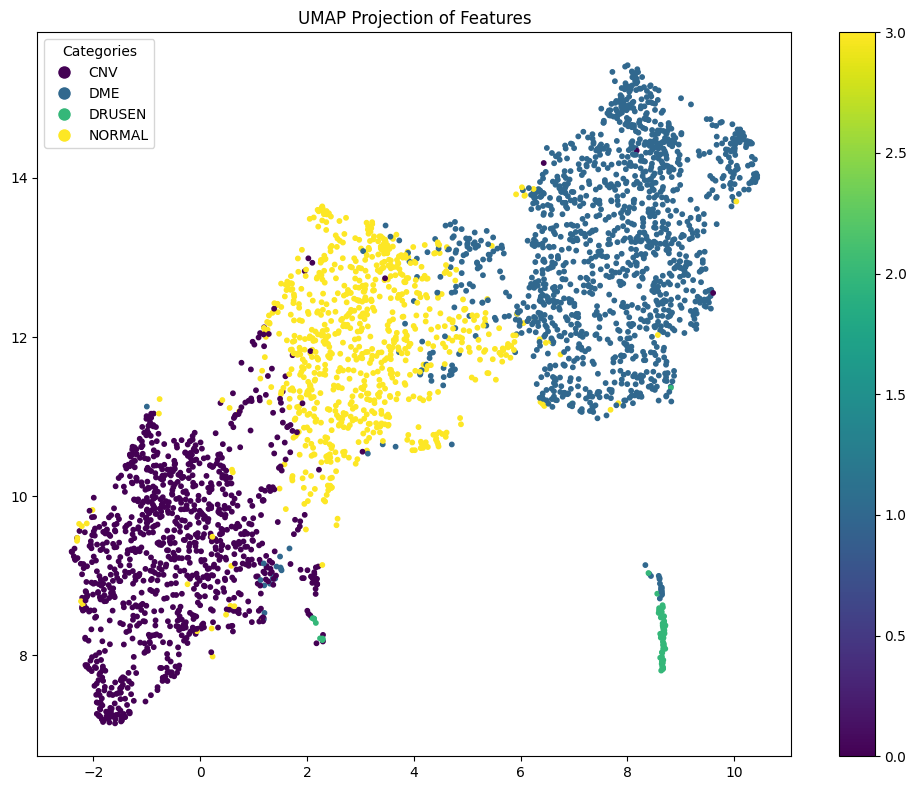

In [16]:
KMeansMetrics(conv_features, conv_labels4)
plot_features(conv_features, conv_labels4)

In [22]:
avgpool_layer = resnet50_features.avgpool
hook_avgpool = avgpool_layer.register_forward_hook(get_activation('avgpool'))

In [23]:
avgpool_features, avgpool_labels = extract_conv_features(test_dataloader, resnet50_features, 'avgpool')
hook_avgpool.remove()

In [24]:
print(f"AveragePool Features shape: {avgpool_features.shape}")
print(f"AveragePool Labels shape: {avgpool_labels.shape}")

AveragePool Features shape: (3400, 2048, 1, 1)
AveragePool Labels shape: (3400,)


In [25]:
# KMeans expects 2D array - samples, features
# flatten features
avgpool_features = avgpool_features.reshape(avgpool_features.shape[0], -1)
print(f"AveragePool Features shape: {avgpool_features.shape}")

AveragePool Features shape: (3400, 2048)


In [26]:
n_clusters = 4

kmeans_avg4 = KMeans(n_clusters=n_clusters, random_state=42).fit(avgpool_features)
avg_labels4 = kmeans_avg4.predict(avgpool_features)
avg_centroids4 = kmeans_avg4.cluster_centers_

              precision    recall  f1-score   support

           0       1.00      0.91      0.95       148
           1       0.99      0.97      0.98       156
           2       0.92      1.00      0.96       162
           3       0.98      0.98      0.98       214

    accuracy                           0.97       680
   macro avg       0.97      0.97      0.97       680
weighted avg       0.97      0.97      0.97       680

Accuracy: 0.9691176470588235


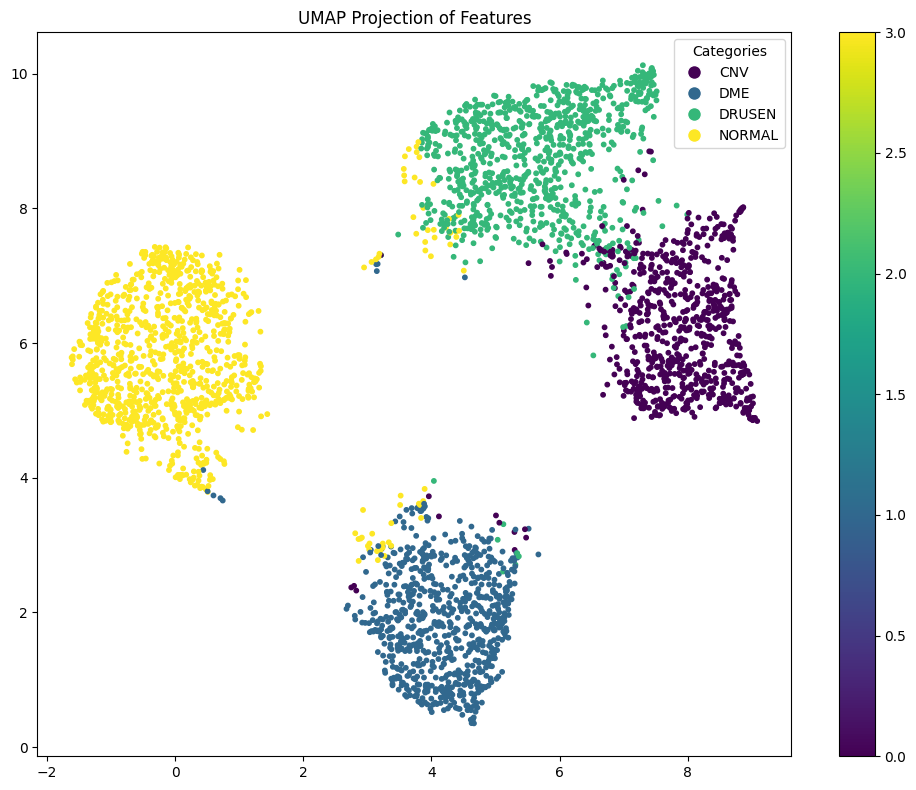

In [47]:
KMeansMetrics(avgpool_features, avg_labels4)
plot_features(avgpool_features, avg_labels4)